# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import RegexpTokenizer
from collections import Counter 
from sklearn import preprocessing
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import re
import string
from nltk.corpus import stopwords
import matplotlib.cm as cm
from matplotlib import rcParams
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [2]:
df_true = pd.read_csv('True.csv')
df_fake = pd.read_csv('Fake.csv')

In [3]:
df_true['label']='fake'
df_fake['label']='true'

df = pd.concat([df_true, df_fake], axis=0)

In [4]:
df.shape

(44898, 5)

In [5]:
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",fake
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",fake
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",fake
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",fake
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",fake


# Data Preprocessing

In [6]:
data=df[['text','label']]

In [7]:
data.head()

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,fake
1,WASHINGTON (Reuters) - Transgender people will...,fake
2,WASHINGTON (Reuters) - The special counsel inv...,fake
3,WASHINGTON (Reuters) - Trump campaign adviser ...,fake
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,fake


In [8]:
data['text']=data['text'].str.lower()

In [9]:
data['label'].unique()

array(['fake', 'true'], dtype=object)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44898 non-null  object
 1   label   44898 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


# Exploratory Data Analysis

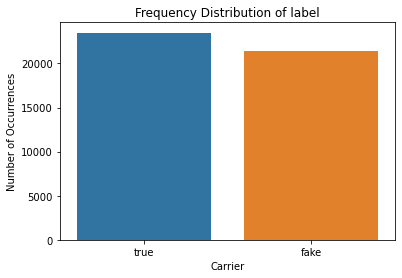

In [11]:
%matplotlib inline
label_count = data["label"].value_counts()
sns.barplot(label_count.index, label_count.values)
plt.title('Frequency Distribution of label')
plt.ylabel('Number of Occurrences')
plt.xlabel('Carrier')
plt.show()

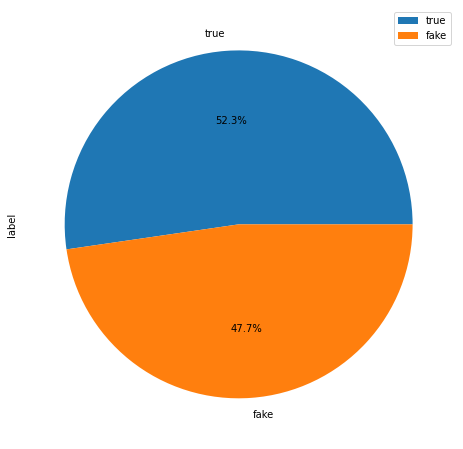

In [12]:
data["label"].value_counts().head(3).plot(kind = 'pie', autopct='%1.1f%%', figsize=(8, 8)).legend()

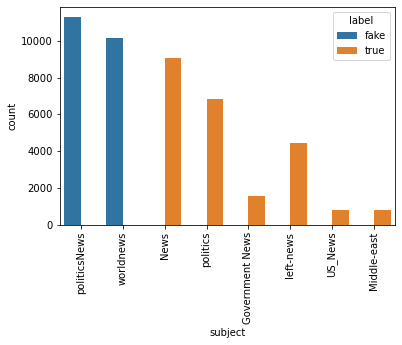

In [13]:
sns.countplot(x='subject',hue='label',data=df)
plt.xticks(rotation=90)
plt.show()

In [14]:
data["label"].value_counts()

true    23481
fake    21417
Name: label, dtype: int64

In [15]:
#Preproccessing of words
data.loc[data["text"].str.contains('america'), 'text'] = 'american'
data.loc[data["text"].str.contains('americans'), 'text'] = 'american'
data.loc[data["text"].str.contains('youore'), 'text'] = 'you are'
data.loc[data["text"].str.contains('youre'), 'text'] = 'you are'
data.loc[data["text"].str.contains('years'), 'text'] = 'year'
data.loc[data["text"].str.contains('break'), 'text'] = 'breakingnews'
data.loc[data["text"].str.contains('breaking'), 'text'] = 'breakingnews'
data.loc[data["text"].str.contains('caused'), 'text'] = 'cause'
data.loc[data["text"].str.contains('causes'), 'text'] = 'cause'
data.loc[data["text"].str.contains('county'), 'text'] = 'country'

In [16]:
for letter in '1234567890.(/':
    data["text"] = data["text"].str.replace(letter,'')

In [17]:
#Preprocess data on Descripcion
english_punctuations = string.punctuation
punctuations_list = english_punctuations + english_punctuations

def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [18]:
#Remove_repeating_char
def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [19]:
#ProcessPost for applying all functions
def processPost(text): 
    text = re.sub('@[^\s]+', ' ', text)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    text= remove_punctuations(text)
    text=remove_repeating_char(text)
    return text

In [20]:
#Applying processPost function for preprocessing
data["text"] = data["text"].apply(lambda x: processPost(x))

In [21]:
#Getting Tokenization
tokenizer = RegexpTokenizer(r'\w+')
data["text"] = data["text"].apply(tokenizer.tokenize)

In [22]:
data["text"].head()

0                                               [year]
1                                           [american]
2    [washington, reuters, the, special, counsel, i...
3                                           [american]
4                                           [american]
Name: text, dtype: object

In [23]:
#Stopwords download
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
stopwords_list = stopwords.words('english')

In [25]:
data["text"]=data["text"].apply(lambda x: [item for item in x if item not in stopwords_list])

In [26]:
#Features Extraction From the texts-Text
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features =1000)

In [27]:
#Preparing features for training and testing
unigramdataGet= word_vectorizer.fit_transform(data['text'].astype('str'))
unigramdataGet = unigramdataGet.toarray()
vocab = word_vectorizer.get_feature_names()
unigramdata=pd.DataFrame(np.round(unigramdataGet, 1), columns=vocab)
unigramdata[unigramdata>0] = 1
unigramdata.head()

,able,absolutely,acept,aces,acording,acount,acr,acros,act,action,...,wrong,wrote,xi,year,yearold,yemen,yes,york,young,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
#Deleteing the text column because we have been extracted features from this
data.reset_index(drop=True, inplace=True)
data=data.drop(columns=['text'])

In [29]:
#Feature selection from the extracted features of unigram
selector = SelectKBest(chi2, k=700)
selector.fit(unigramdata, data['label'])

unigramdata = selector.transform(unigramdata)
print(unigramdata.shape)

(44898, 700)


In [30]:
#DEpendent and independent features
X=unigramdata
y=data['label']

In [31]:
#Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=100)

# Apply SVM Support Vector Machine Algorithm - SVC for classification problem


In [32]:
svc = LinearSVC(C=1, max_iter=500)
svc = svc.fit(X_train , y_train)

In [33]:
#Check accuracy
y_pred1 = svc.predict(X_test)
accuracy_score =s vc.score(X_test, y_test)
print('Accuracy score= {:.2f}'.format(accuracy_score))

SyntaxError: invalid syntax (<ipython-input-33-cd173939bb6a>, line 3)

In [ ]:
#Check confusion matrix
print("confusion matrix")
confusion_matrix_svc = confusion_matrix(y_test, y_pred1)
print(confusion_matrix_svc)

# Apply Logistic Regression

In [ ]:
log_model = LogisticRegression()
log_model = log_model.fit(X_train , y_train)

In [ ]:
#Check accuracy
y_pred1 = log_model.predict(X_test)
accuracy_scor_log = log_model.score(X_test, y_test)
print('Accuracy score= {:.2f}'.format(accuracy_scor_log))

In [ ]:
#Check confusion Matrix
print("confusion matrix")
confusion_matrix_log = confusion_matrix(y_test, y_pred1)
print(confusion_matrix_log)